In [1]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import scipy.io as sio
import netCDF4 as nc
import glob, os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] =10000000000000000000000000.0
import cmocean
import xarray as xr

In [3]:
%cd /work/eay/MITgcm_data/Experiment22/
file0 = nc.Dataset('Temp.nc')
file1 = nc.Dataset('Salt.nc')
file2 = nc.Dataset('U.nc')
file3 = nc.Dataset('V.nc')
NX = 600
NY = 1000
NZ = 120
grid = nc.Dataset('grid.nc')
depth = (grid.variables['Depth'][:])

xq = (file1.variables['X'][:])
yq = (file1.variables['Y'][:])
zl = (file1.variables['Z'][:])
Time = file1.variables['T'][:]
print(Time.shape)

xqmat=np.tile(xq,(NY,1))
yqmat=np.tile(yq,(NX,1))
yqmat=np.transpose(yqmat)
print(yqmat.shape)
print(xqmat.shape)
%cd /work/eay/MITgcm_data/

/work2/eay/MITgcm_data/Experiment22
(150,)
(1000, 600)
(1000, 600)
/work2/eay/MITgcm_data


In [4]:
mask = file1.variables['S'][30,0,:,:]
mask.shape

#Reading in salinity
index = 149
Salt = file1.variables['S'][index,0,:,:]
Salt[mask==0]=np.nan

In [5]:
#Computing freshwater layer
newmask = file1.variables['S'][0,:,:,:]


Salt_h = file1.variables['S'][index,:,:,:]; Salt_h[newmask==0]=np.nan
Sref = Salt_h*0.0+34.0
hf=0.1*np.nansum((Sref-Salt_h)/34.0,axis=0)
hf[(mask==0)]=np.nan
###hf(i,j)=0.1*sum((sr-s(i,j,:))/sr); (your delta z is 0.1 correct?)###


In [6]:
def wright_eos(T,S,p):
  """                                                                                                                                                                                                              
                                                                                                                                                                                                                   
 **********************************************************************                                                                                                                                            
   The subroutines in this file implement the equation of state for   *                                                                                                                                            
   sea water using the formulae given by  Wright, 1997, J. Atmos.     *                                                                                                                                            
   Ocean. Tech., 14, 735-740.  Coded by R. Hallberg, 7/00.            *                                                                                                                                            
 ***********************************************************************                                                                                                                                           
    Converted to Python from F90 by M Harrison 10/11.                                                                                                                                                              
                                                                                                                                                                                                                   
 Calculate seawater equation of state, given T[degC],S[PSU],p[Pa]                                                                                                                                                  
 Returns density [kg m-3]                                                                                                                                                                                          
                                                                                                                                                                                                                   
 ***********************************************************************                                                                                                                                           
                                                                                                                                                                                                                   
 """

  a0 = 7.057924e-4; a1 = 3.480336e-7; a2 = -1.112733e-7;
  b0 = 5.790749e8;  b1 = 3.516535e6;  b2 = -4.002714e4;
  b3 = 2.084372e2;  b4 = 5.944068e5;  b5 = -9.643486e3;
  c0 = 1.704853e5;  c1 = 7.904722e2;  c2 = -7.984422;
  c3 = 5.140652e-2; c4 = -2.302158e2; c5 = -3.079464;

  al0 = a0 + a1*T +a2*S
  p0  = b0 + b4*S + T * (b1 + T*(b2 + b3*T) + b5*S)
  lam = c0 +c4*S + T * (c1 + T*(c2 + c3*T) + c5*S)
  I_denom = 1.0 / (lam + al0*(p+p0))
  rho = (p + p0) * I_denom

  return rho

In [7]:
import sys
import numpy as np

__doc__ = """
Density of Sea Water using McDougall et al. 2003 (JAOT 20) polynomial
"""
# coefficients nonlinear equation of state in pressure coordinates for
eosMDJWFnum =  [ 7.35212840e+00,
                -5.45928211e-02,
                 3.98476704e-04,
                 2.96938239e+00,
                -7.23268813e-03,
                 2.12382341e-03,
                 1.04004591e-02,
                 1.03970529e-07,
                 5.18761880e-06,
                -3.24041825e-08,
                -1.23869360e-11,
                 9.99843699e+02 ]
eosMDJWFden =  [ 7.28606739e-03,
                -4.60835542e-05,
                 3.68390573e-07,
                 1.80809186e-10,
                 2.14691708e-03,
                -9.27062484e-06,
                -1.78343643e-10,
                 4.76534122e-06,
                 1.63410736e-09,
                 5.30848875e-06,
                -3.03175128e-16,
                -1.27934137e-17,
                 1.00000000e+00 ]
def densmdjwf(s,theta,p):
    """
    Computes in-situ density of sea water
    Density of Sea Water using McDougall et al. 2003 (JAOT 20)
    polynomial (Gibbs Potential).

    Parameters
    ----------
    s : array_like
        salinity [psu (PSS-78)]
    theta : array_like
        potential temperature [degree C (IPTS-68)];
        same shape as s
    p : array_like
        pressure [dbar]; broadcastable to shape of s

    Returns
    -------
    dens : array
        density [kg/m^3]

    Example
    -------
    >>> densmdjwf(35., 25., 2000.)
    1031.654229

    Notes
    -----
    AUTHOR:  Martin Losch 2002-08-09  (Martin.Losch@awi.de)

    McDougall et al., 2003, JAOT 20(5), pp. 730-741
    """
    
    # make sure arguments are floating point
    s = np.asfarray(s)
    t = np.asfarray(theta)
    p = np.asfarray(p)

    p1 = np.copy(p);
    
    t1 = np.copy(t);
    t2 = t*t;
    
    s1 = np.copy(s);
    if np.any(s1<0):
        sys.stderr.write('negative salinity values! setting to nan\n')
        # # the sqrt will take care of this
        # if s.ndim > 0:
        #     s[s<0] = np.nan
        # else:
        #     s = np.nan
    sp5 = np.sqrt(s1)
    p1t1=p1*t1
    num = ( eosMDJWFnum[11] 
            + t1*(eosMDJWFnum[0]
                  + t1*(eosMDJWFnum[1] + eosMDJWFnum[2]*t1) )
            + s1*(eosMDJWFnum[3]
                  + eosMDJWFnum[4]*t1  + eosMDJWFnum[5]*s1)
            + p1*(eosMDJWFnum[6] + eosMDJWFnum[7]*t2
                  + eosMDJWFnum[8]*s1
                  + p1*(eosMDJWFnum[9] + eosMDJWFnum[10]*t2) )
    )
    den = ( eosMDJWFden[12]
            + t1*(eosMDJWFden[0]
                  + t1*(eosMDJWFden[1]
                        + t1*(eosMDJWFden[2] + t1*eosMDJWFden[3] ) ) )
            + s1*(eosMDJWFden[4]
                  + t1*(eosMDJWFden[5]
                        + eosMDJWFden[6]*t2)
                  + sp5*(eosMDJWFden[7] + eosMDJWFden[8]*t2) )
            + p1*(eosMDJWFden[9]
                  + p1t1*(eosMDJWFden[10]*t2 + eosMDJWFden[11]*p1) )
    )
    epsln = 0
    denom = 1.0/(epsln+den)
    rho = num*denom;

    return rho
# aliases
dens = densmdjwf

In [10]:
print(densmdjwf(34., 15., 0.),'MDJWF @ 34psu, 15C')
print(wright_eos(15., 34., 0.),'Wright @ 34psu, 15C')

1025.2031586387247 MDJWF @ 34psu, 15C
1025.2022031329202 Wright @ 34psu, 15C


In [11]:
#Computing inverse Froude number

mask3D = file1.variables['S'][0,:,:,:]
Temp = file0.variables['Temp'][index,:,:,:]; Temp[mask3D==0]=np.nan
Salt_fr = file1.variables['S'][index,:,:,:]; Salt_fr[mask3D==0]=np.nan
Sref = Salt_fr*0.0+34.0
hf_fr=0.1*np.nansum((Sref-Salt_fr)/34.0,axis=0)
hf_fr[(mask==0)]=np.nan

drho= densmdjwf(34.,15.,0)-densmdjwf(0.,15.,0);
rho_o=densmdjwf(34.,15.,0);
C_int=np.sqrt(9.81*drho*hf_fr/rho_o)
#drho= wright_eos(15.,34.,0)-wright_eos(15.,0.,0);
#rho_o=wright_eos(15.,34.,0);

U = (file2.variables['U'][index,:,:,1:]+file2.variables['U'][index,:,:,:-1])/2
V = (file3.variables['V'][index,:,1:,:]+file3.variables['V'][index,:,:-1,:])/2
velocity = np.sqrt(U**2+V**2) 


In [16]:
#Computing the inverse froude number by using velocity averaged over plume depth:

%cd /work/eay/MITgcm_data/Experiment22/
Stemp = xr.open_dataset('Salt.nc')['S'][index,:,:,:]
Stemp=Stemp.where(Stemp>0)
thickness = (abs((34-Stemp)*Stemp.Z*0.1).sum(axis=0)/abs((34-Stemp)*0.1).sum(axis=0)).round(1)
#thickness.plot()

test1=Stemp*0+1.
surfmask=(test1.where(test1.Z>-thickness.round(1)*2)*0+1.).values
%cd /work/eay/MITgcm_data/

velocity_s=np.nanmean(velocity*surfmask,axis=0)
C_int[np.isnan(velocity_s)]=1e-20; velocity_s[np.isnan(velocity_s)]=1e-15;  #just to avoid NaN issues
velocity_s[mask==0] = np.nan

Fr = velocity_s/C_int; 
Inv_Fr=C_int/velocity_s

/work2/eay/MITgcm_data/Experiment22
/work2/eay/MITgcm_data


/vftmp/Elizabeth.Yankovsky/pid14245/ipykernel_12609/335923026.py:13: RuntimeWarning: Mean of empty slice
  velocity_s=np.nanmean(velocity*surfmask,axis=0)


In [17]:
Inv_Fr.shape

(1000, 600)

In [1]:
fig = plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.1,0.7,0.7])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([.9, 0.1, 0.05, 0.7])

Inv_Fr[mask==0]=np.nan
current_cmap = plt.cm.get_cmap(cmocean.cm.matter_r).copy()
current_cmap.set_bad(color='silver')
quad1 = ax1.pcolormesh(xq/1000,yq/1000,Inv_Fr,cmap=current_cmap,shading='gouraud',vmin=0,vmax=1.)
#ax1.set_xlim(0,30)
ax1.set_title('Inverse Froude number, day=%04.2f ' %(index/48.), fontsize=14)
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('X Position (km)',fontsize=14)
ax1.set_ylabel('Y Position (km)',fontsize=14)
cb1 = fig.colorbar(quad1,ax2)

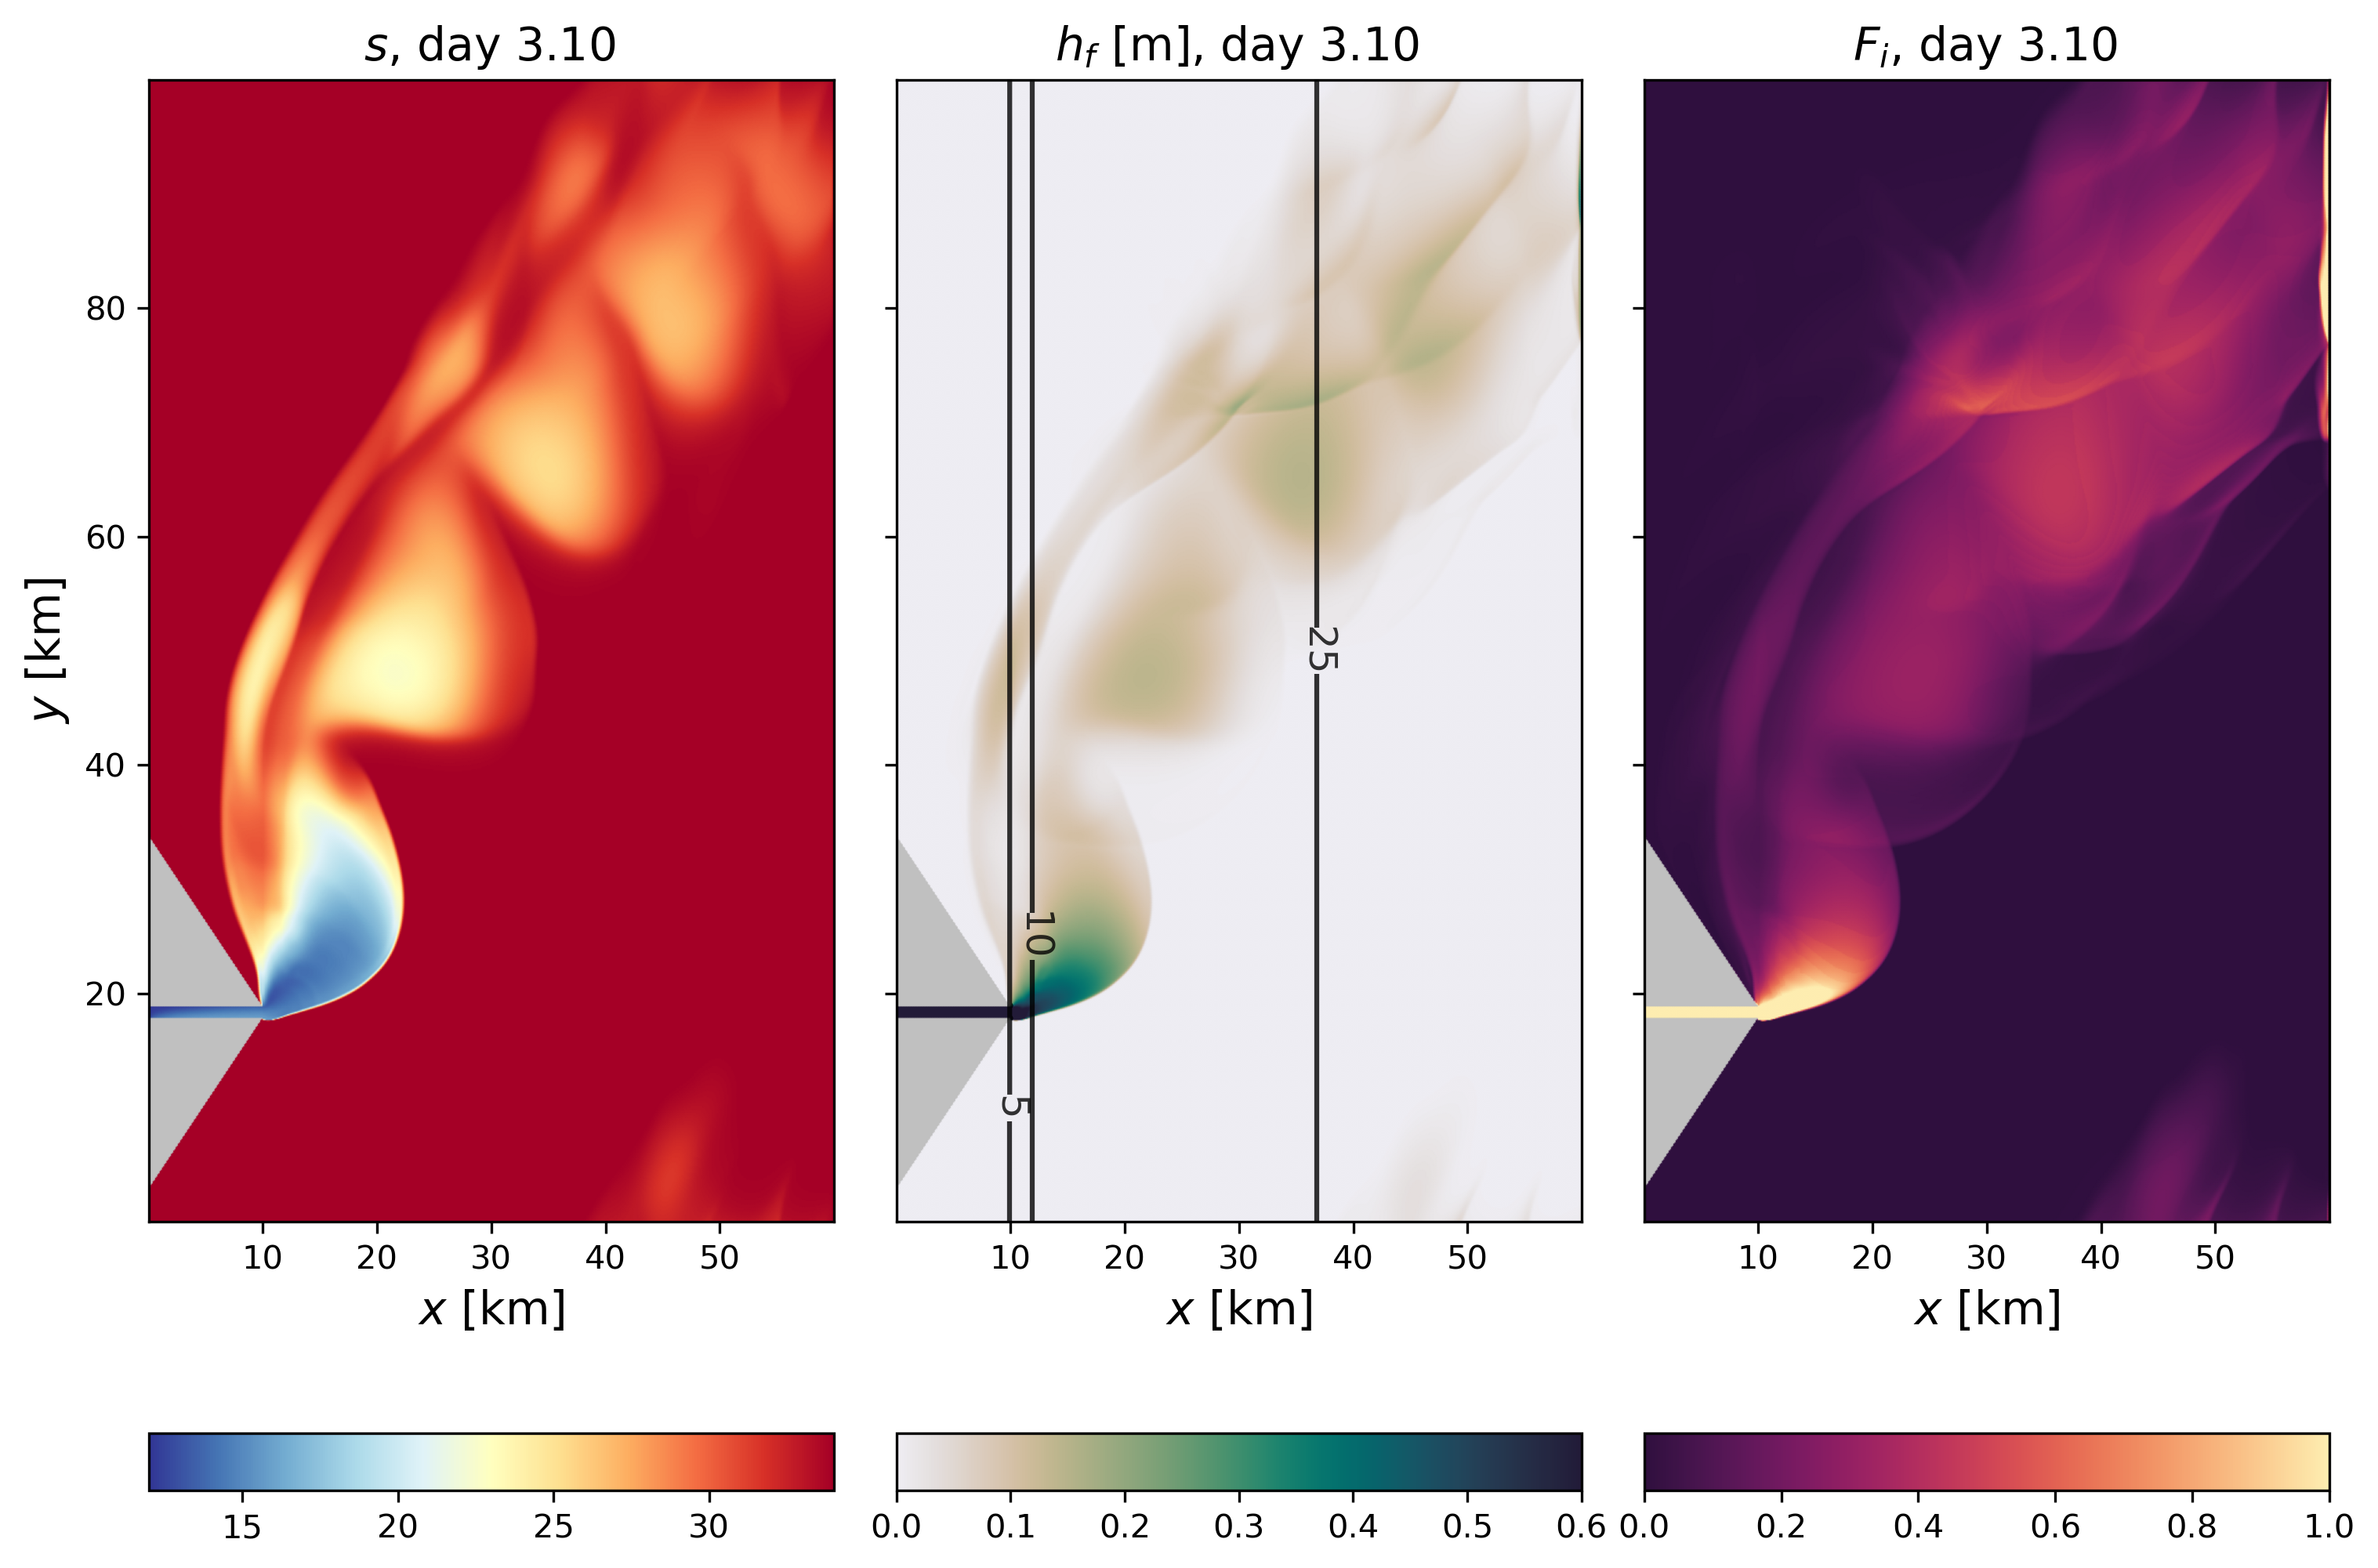

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(10.6, 10), dpi= 300, facecolor='w', edgecolor='k')
#main plots
ax1 = fig.add_axes([0.15,0.2,0.3,0.6])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax2 = fig.add_axes([0.45,0.2,0.3,0.6])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
ax3 = fig.add_axes([0.75,0.2,0.3,0.6])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)


#FIRST SUBPLOT
current_cmap = plt.cm.get_cmap("RdYlBu_r").copy()
current_cmap.set_bad(color='silver')
quad1 = ax1.pcolormesh(xq/1000,yq/1000,Salt,cmap=current_cmap,vmin=12.,vmax=34.,shading='gouraud')
ax1.set_title('$s$, day %04.2f ' %(index/48.), fontsize=14)
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('$x$ [km]',fontsize=14)
ax1.set_ylabel('$y$ [km]',fontsize=14)
ax1.set_aspect('equal'); #ax1.set_xlim([0, 30]); ax1.set_ylim([35,85])
divider1 = make_axes_locatable(ax1); cax1 = divider1.new_vertical(size="5%", pad=0.9, pack_start=True)
fig.add_axes(cax1); fig.colorbar(quad1, cax=cax1, orientation="horizontal")
#ax1.text(0.05, 0.9, '$a$', transform=ax1.transAxes,fontsize=25)

current_cmap = plt.cm.get_cmap(cmocean.cm.rain).copy()
current_cmap.set_bad(color='silver')
quad2 = ax2.pcolormesh(xq/1000,yq/1000,hf,cmap=current_cmap,shading='gouraud',vmin=0,vmax=.6)
ax2.set_title('$h_f$ [m], day %04.2f ' %(index/48.), fontsize=14)
ax2.set_facecolor((0.92, 0.92, 0.92))
ax2.axes.set_yticklabels([])
ax2.set_xlabel('$x$ [km]',fontsize=14)
ax2.set_aspect('equal'); #ax2.set_xlim([0, 30]); ax2.set_ylim([35,85])
divider2 = make_axes_locatable(ax2); cax2 = divider2.new_vertical(size="5%", pad=0.9, pack_start=True)
fig.add_axes(cax2); fig.colorbar(quad2, cax=cax2, orientation="horizontal")
#ax2.text(0.05, 0.9, '$b$',transform=ax2.transAxes,fontsize=25)
#Adding isobath labels
CS=ax2.contour(xq/1000, yq/1000, depth, [5.,10.,24.99],colors='k',alpha=0.8)
manual_locations = [(8, 10), (12, 25), (38, 50)]
ax2.clabel(CS, fontsize=12,fmt = '%1.0f',manual=manual_locations)

current_cmap = plt.cm.get_cmap(cmocean.cm.matter_r).copy()
current_cmap.set_bad(color='silver')
quad3 = ax3.pcolormesh(xq/1000,yq/1000,Inv_Fr,cmap=current_cmap,shading='gouraud',vmin=0,vmax=1.)
ax3.set_title('$F_i$, day %04.2f ' %(index/48.), fontsize=14)
ax3.set_facecolor((0.92, 0.92, 0.92))
ax3.axes.set_yticklabels([])
ax3.set_xlabel('$x$ [km]',fontsize=14)
ax3.set_aspect('equal'); #ax3.set_xlim([0, 30]); ax3.set_ylim([35,85])
divider3 = make_axes_locatable(ax3); cax3 = divider3.new_vertical(size="5%", pad=0.9, pack_start=True)
fig.add_axes(cax3); fig.colorbar(quad3, cax=cax3, orientation="horizontal")
#ax3.text(0.05, 0.9, '$c$',transform=ax3.transAxes,fontsize=25)
plt.show()

#fig.savefig('Figure1.png', format='png', dpi=600)